<a href="https://colab.research.google.com/github/cuixx289/STAT6289-Final-project/blob/main/Final_DCGAN_gender_classification_Mingyang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32*GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/gender/'
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"The generated square images is {GENERATE_SQUARE}px.")

The generated square images is 96px.


In [ ]:
# The dataset has over 8500 images 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_96_96.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            114),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            114,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1. #Reduce runing time


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/gender/training_data_96_96.npy
Loading previous training pickle...



We will use a TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.layers import Input,Conv2D,Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten, AvgPool2D,InputLayer,GlobalAveragePooling2D,LSTM,Embedding,Conv2DTranspose,Reshape

# Build generator and discriminator funtion

The architecture of buiding generator and discriminator function for our DCGANs models are following:

1.Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

2.Instead of using BatchNormal,we use Random normalization(0,0.02) in both the generator and the discriminator to prevent the vanishing gradient problem.

3.Remove fully connected hidden layers for deeper architectures.

4.Instead of using Relu, we use LeakyReLU activation in generator for all layers except for the output, which uses Tanh.

5.Use LeakyReLU activation in the discriminator for all layers.

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=(3,3),padding="same"
                          ,kernel_initializer=RandomNormal(0, 0.02)))
    
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=(3,3),padding="same"
                          ,kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(alpha=0.2))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=(3,3),padding="same"
                          ,kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
    model.add(Conv2D(128,kernel_size=3,padding="same"
            ,kernel_initializer=RandomNormal(0, 0.02)))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=(3,3),padding="same",activation = 'tanh'))

    
    return model

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3,3), strides=2
                     , padding="same"))
    model.add(BatchNormalization(momentum=0.9))

    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=(3,3), strides=2
                     , padding="same"))
    model.add(BatchNormalization(momentum=0.9))

    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=(3,3), strides=1
                     , padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1,
                     padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Save training images
As we progress through training images will be produced to show the progress. These images will contain a number of rendered faces that show how good the generator has become. These faces will be

In [ ]:
# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 1

def save_images(cnt,noise):
  image_array = np.full(( 
      (PREVIEW_ROWS * (GENERATE_SQUARE)), 
      (PREVIEW_COLS * (GENERATE_SQUARE)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16)
        c = col * (GENERATE_SQUARE+16)
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'DCGAN_faces2')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)


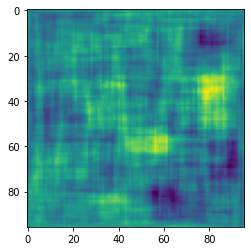

In [ ]:

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49822906]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer
Both the generator and discriminator use Adam optimizer and the same learning rate (0.00005) and momentum(0.5). This does not need to be the case. If you use a GENERATE_RES greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.



In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.5)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    save_images(epoch,fixed_seed)


# Training

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.0692808628082275,disc loss=0.6567711234092712
Epoch 2, gen loss=2.4704339504241943,disc loss=0.4836638867855072
Epoch 3, gen loss=2.361187219619751,disc loss=0.5871432423591614
Epoch 4, gen loss=2.162529945373535,disc loss=0.8804497718811035
Epoch 5, gen loss=2.2141544818878174,disc loss=0.8176508545875549
Epoch 6, gen loss=2.0184216499328613,disc loss=0.9108719229698181
Epoch 7, gen loss=2.142500638961792,disc loss=0.814805805683136
Epoch 8, gen loss=2.0892722606658936,disc loss=0.8471730351448059
Epoch 9, gen loss=2.049363851547241,disc loss=0.8565255999565125
Epoch 10, gen loss=2.1548900604248047,disc loss=0.8178112506866455
Epoch 11, gen loss=2.043853998184204,disc loss=0.8601076006889343
Epoch 12, gen loss=2.0345308780670166,disc loss=0.8788862824440002
Epoch 13, gen loss=2.215101718902588,disc loss=0.7901207208633423
Epoch 14, gen loss=2.0942070484161377,disc loss=0.8168736696243286
Epoch 15, gen loss=2.1732282638549805,disc loss=0.7944672107696533
Epoch 16, g

# Convert generated female images to GIF

In [ ]:
import os
import imageio

GAN_face_dir = '/content/drive/My Drive/gender/female/test_female2'

images = []

for file_name in os.listdir(GAN_face_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(GAN_face_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/drive/My Drive/gender/female_movie.gif', images)

# Convert male images to GIF

In [ ]:
GAN_face_dir = '/content/drive/My Drive/gender/good_male/'

images = []

for file_name in os.listdir(GAN_face_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(GAN_face_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/drive/My Drive/gender/movie.gif', images)

# Save the model

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))